<a href="https://colab.research.google.com/github/char704/Panorama/blob/main/panorama.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Method 1: Step by Step

In [4]:
import cv2
import numpy as np

# Method 1: Step-by-Step Stitching
def stitch_two_images(img1, img2):
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)
    good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
    if len(good_matches) < 4:
        print("Not enough good matches found.")
        return None
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    H, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
    if H is None:
        print("Homography estimation failed.")
        return None
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    corners_img1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    corners_img2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
    warped_corners_img2 = cv2.perspectiveTransform(corners_img2, H)
    all_corners = np.concatenate((corners_img1, warped_corners_img2), axis=0)
    min_x = np.min(all_corners[:, :, 0])
    max_x = np.max(all_corners[:, :, 0])
    min_y = np.min(all_corners[:, :, 1])
    max_y = np.max(all_corners[:, :, 1])
    width = int(max_x - min_x + 0.5)
    height = int(max_y - min_y + 0.5)
    T = np.array([[1, 0, -min_x], [0, 1, -min_y], [0, 0, 1]], dtype=np.float32)
    warped_img1 = cv2.warpPerspective(img1, T, (width, height))
    warped_img2 = cv2.warpPerspective(img2, T @ H, (width, height))
    mask1 = np.ones((h1, w1), dtype=np.uint8)
    mask2 = np.ones((h2, w2), dtype=np.uint8)
    warped_mask1 = cv2.warpPerspective(mask1, T, (width, height), flags=cv2.INTER_NEAREST)
    warped_mask2 = cv2.warpPerspective(mask2, T @ H, (width, height), flags=cv2.INTER_NEAREST)
    panorama = np.zeros((height, width, 3), dtype=np.float32)
    mask1_region = (warped_mask1 > 0)[:, :, np.newaxis]
    mask2_region = (warped_mask2 > 0)[:, :, np.newaxis]
    panorama += warped_img1.astype(np.float32) * mask1_region
    panorama += warped_img2.astype(np.float32) * mask2_region
    count = (warped_mask1 > 0).astype(np.float32) + (warped_mask2 > 0).astype(np.float32)
    panorama /= np.maximum(count[:, :, np.newaxis], 1)
    panorama = np.clip(panorama, 0, 255).astype(np.uint8)
    return panorama

def stitch_multiple_images_step_by_step(images):
    if len(images) < 2:
        raise ValueError("At least two images are required for stitching.")
    result = images[0]
    for i in range(1, len(images)):
        result = stitch_two_images(result, images[i])
        if result is None:
            print(f"Failed to stitch image {i + 1}.")
            return None
    return result

Method 2: Sticher(mask, Inpainting)

In [5]:
def stitch_images_using_stitcher(images):
    if len(images) < 2:
        raise ValueError("At least two images are required for stitching.")
    stitcher = cv2.Stitcher_create()
    status, panorama = stitcher.stitch(images)
    if status == cv2.Stitcher_OK:
        # Tạo mask cho vùng đen
        gray = cv2.cvtColor(panorama, cv2.COLOR_BGR2GRAY)
        mask = (gray == 0).astype(np.uint8) * 255  # Vùng đen có giá trị 0
        # Inpainting
        panorama_filled = cv2.inpaint(panorama, mask, 3, cv2.INPAINT_TELEA)
        return panorama_filled
    else:
        print(f"Stitching failed with status code: {status}")
        return None

Usage

In [6]:
# Usage code for both methods
# Load images and stitch them
images = [cv2.imread('/content/1.jpg'), cv2.imread('/content/2.jpg'),cv2.imread('/content/3.jpg'),cv2.imread('/content/4.jpg')]  # Replace with your image paths

# Method 1: Step-by-Step Stitching
panorama_step_by_step = stitch_multiple_images_step_by_step(images)
if panorama_step_by_step is not None:
    cv2.imwrite('panorama_step_by_step.jpg', panorama_step_by_step)
    print("Step-by-step panorama saved as 'panorama_step_by_step.jpg'")
else:
    print("Step-by-step stitching failed.")

# Method 2: OpenCV Stitcher
panorama_stitcher = stitch_images_using_stitcher(images)
if panorama_stitcher is not None:
    cv2.imwrite('panorama_stitcher.jpg', panorama_stitcher)
    print("Stitcher panorama saved as 'panorama_stitcher.jpg'")
else:
    print("Stitcher stitching failed.")

Step-by-step panorama saved as 'panorama_step_by_step.jpg'
Stitcher panorama saved as 'panorama_stitcher.jpg'


Image before panorama

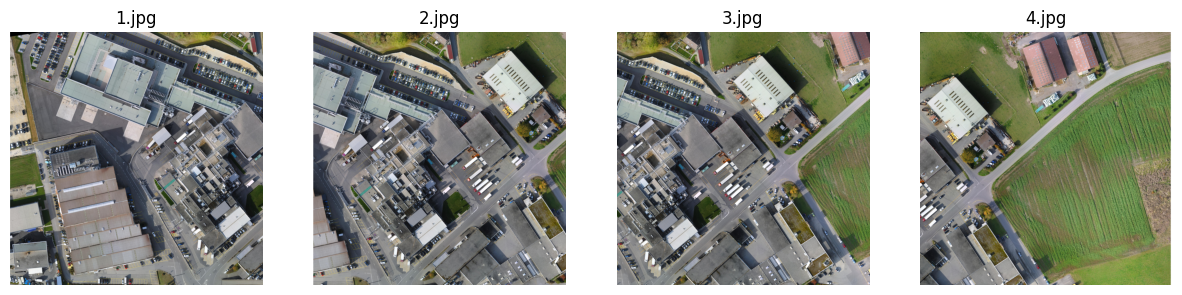

In [12]:
import matplotlib.pyplot as plt

def show_images(img3_path, img4_path, img5_path, img6_path):
    img3 = cv2.imread(img3_path)[:, :, ::-1]
    img4 = cv2.imread(img4_path)[:, :, ::-1]
    img5 = cv2.imread(img5_path)[:, :, ::-1]
    img6 = cv2.imread(img6_path)[:, :, ::-1]

    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    axes[0].imshow(img3)
    axes[0].set_title("1.jpg")
    axes[1].imshow(img4)
    axes[1].set_title("2.jpg")
    axes[2].imshow(img5)
    axes[2].set_title("3.jpg")
    axes[3].imshow(img6)
    axes[3].set_title("4.jpg")
    for ax in axes:
        ax.axis("off")

    plt.show()

show_images("1.jpg","2.jpg","3.jpg","4.jpg")


After panorama

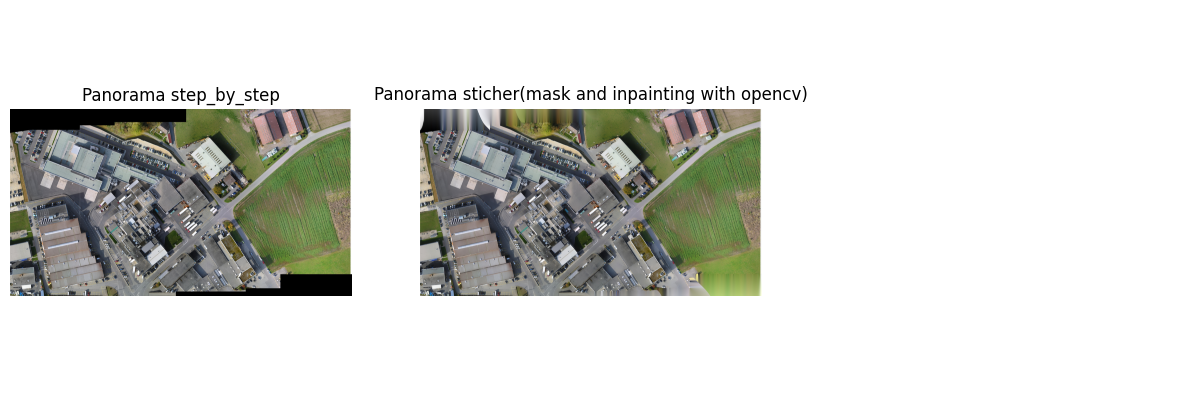

In [10]:
import matplotlib.pyplot as plt

def show_images(img1_path, img2_path):
    img1 = cv2.imread(img1_path)[:, :, ::-1]  # Convert BGR to RGB
    img2 = cv2.imread(img2_path)[:, :, ::-1]


    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img1)
    axes[0].set_title("Panorama step_by_step")
    axes[1].imshow(img2)
    axes[1].set_title("Panorama sticher(mask and inpainting with opencv)")

    for ax in axes:
        ax.axis("off")

    plt.show()

show_images("panorama_step_by_step.jpg", "panorama_stitcher.jpg")